In [27]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import xgboost as xgb
import HomeMade as hm
import pandas as pd

In [140]:
ML1 = "v0_chi2 v0_px1 v0_phi1 v0_py1 v0_py v0_py2 v0_phi2 v0_px2 v0_px".split(" ")
# ML1 = "v0_chi2 v0_px1 v0_py1 v0_py v0_py2 v0_px2 v0_px".split(" ")
ML2 = "cosTheta a0xy a0 v0_y v0_x v0_rxyErr v0_rxy v0_z pv0_z pv0_y ntrk_pv0 pv0_x".split(" ")

In [88]:
N = 4e6

mass_range = (1090,1145)

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(["v0_la_mass"]+ML1+ML2, entrystop = N)

data = data.loc[(data.v0_la_mass > mass_range[0]) & (data.v0_la_mass < mass_range[1])]
# train_split_data = len(data)//3
train_test_split_data = int(len(data)*0.5)
train_data = data[:train_test_split_data]
test_data = data[train_test_split_data:]

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(["v0_la_mass"]+ML1+ML2+['trueLa'], entrystop = N)

mc = mc.loc[(mc.v0_la_mass > mass_range[0]) & (mc.v0_la_mass < mass_range[1])]
train_test_split_mc = int(len(data)*0.8)
train_mc = mc[:train_test_split_mc]
test_mc = mc[train_test_split_mc:]

In [147]:
def reweight_train(data,mc,feats,cla,reweight_feats=None,eval_data=None,eval_mc=None,plot=True,reweighing=True,q_weights=0.9999):
    from sklearn.preprocessing import RobustScaler, MinMaxScaler
    from hep_ml.reweight import GBReweighter
    from sklearn.metrics import roc_curve, roc_auc_score

    scaler_mc = MinMaxScaler()
    scaler_data = MinMaxScaler()

    def remove_outliers(data,q1=0.05,q2=0.95):
        mask = np.ones(len(data),dtype=bool)
        for col in data.columns:
            mask *= data[col].between(data[col].quantile(q1),data[col].quantile(q2)).to_numpy()
        return mask
    
    #Try and remove outliers at first step
    data = data[remove_outliers(data[feats])]
    mc = mc[remove_outliers(mc[feats])]
    
    data_split = len(data)//2
    mc_split = len(mc)//2
    
    train_data = data[:data_split]
    train_data_cla = data[data_split:]
    
    train_mc = mc[:mc_split]
    train_mc_cla = mc[mc_split:]
    
#     scaled_train_data = pd.DataFrame(scaler_data.fit_transform(train_data[feats][remove_outliers(train_data[feats])]),columns=feats)
#     scaled_train_mc = pd.DataFrame(scaler_mc.fit_transform(train_mc[feats][remove_outliers(train_mc[feats])]),columns=feats)
    scaled_train_data = pd.DataFrame(scaler_data.fit_transform(train_data[feats]),columns=feats)
    scaled_train_mc = pd.DataFrame(scaler_mc.fit_transform(train_mc[feats]),columns=feats)

    scaled_train_data_cla = pd.DataFrame(scaler_data.transform(train_data_cla[feats]),columns=feats)
    scaled_train_mc_cla = pd.DataFrame(scaler_mc.transform(train_mc_cla[feats]),columns=feats)
    
#     #Try and remove outliers
#     scaled_train_data_cla[remove_outliers(scaled_train_data_cla)]
#     scaled_train_mc_cla[remove_outliers(scaled_train_mc_cla)]
    
    if plot:
        for feat in feats:
            scaled_train_data[feat].hist(bins=100,alpha=0.5);
            scaled_train_mc[feat].hist(bins=100,alpha=0.5);
            plt.yscale('log')
            plt.title(feat)
            plt.show()
    
    if reweighing:
        if not reweight_feats:
            reweight_feats = feats
        reweighter = GBReweighter(n_estimators=100,max_depth=2,min_samples_leaf=800,loss_regularization=10.0)
        sample = min(len(scaled_train_mc),len(scaled_train_data))
        reweighter.fit(original=scaled_train_mc[reweight_feats].sample(sample), target=scaled_train_data[reweight_feats].sample(sample))
        
        mc_weights = reweighter.predict_weights(scaled_train_mc_cla[reweight_feats])
        
        mask = mc_weights < np.quantile(mc_weights, (q_weights))
        
        plt.hist(mc_weights[mask],bins=100)
        plt.yscale('log')
        plt.xscale('log')
        plt.show()
        
        if plot:
            print(len(scaled_train_data_cla),len(scaled_train_mc_cla[mask]))
            for feat in feats:
                scaled_train_data_cla[feat].hist(bins=100,alpha=0.5);
                scaled_train_mc_cla[mask][feat].hist(bins=100,alpha=0.5,weights=mc_weights[mask]);
                plt.yscale('log')
                plt.title(feat)
                plt.show()
        
        cla.fit(X=scaled_train_mc_cla[mask],
               y=train_mc_cla.trueLa[mask],
               sample_weight = mc_weights[mask])
        
        if type(eval_data) != type(None) and type(eval_mc) != type(None):
            scaled_eval_data = pd.DataFrame(scaler_data.transform(eval_data[feats]),columns=feats)
            scaled_eval_mc = pd.DataFrame(scaler_mc.transform(eval_mc[feats]),columns=feats)
            
            #Check how distinguishable after reweighing
            eval_cla = xgb.XGBClassifier()
            eval_cla.fit(X=pd.concat([scaled_train_mc_cla[mask],scaled_train_data_cla]),
                        y=np.append(np.ones(len(scaled_train_mc_cla[mask])),np.zeros(len(scaled_train_data_cla))),
                        sample_weight = np.append(mc_weights[mask],np.ones(len(scaled_train_data_cla))))
            print(eval_cla.feature_importances_)
            
            p_reweight = eval_cla.predict_proba(pd.concat([scaled_eval_data,scaled_eval_mc]))[:,1]
            
            fig, ax = plt.subplots()
            fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_eval_data)),np.ones(len(scaled_eval_mc))),p_reweight)
            ax.plot(fpr,tpr,'b.')
            
            #check before reweighing
            eval_cla = xgb.XGBClassifier()
            eval_cla.fit(X=pd.concat([scaled_train_mc_cla[mask],scaled_train_data_cla]),
                        y=np.append(np.ones(len(scaled_train_mc_cla[mask])),np.zeros(len(scaled_train_data_cla))))
            print(eval_cla.feature_importances_)
            
            p_reweight = eval_cla.predict_proba(pd.concat([scaled_eval_data,scaled_eval_mc]))[:,1]
            
            fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_eval_data)),np.ones(len(scaled_eval_mc))),p_reweight)
            ax.plot(fpr,tpr,'rx')
    else:
        cla.fit(X=scaled_train_mc_cla,
                y=train_mc_cla.trueLa)
    return scaler_data, scaler_mc

Reweighting is hard, some of the following is just to produce figures of models trained in scaled MC and evaluated in data:

In [122]:
cla1 = xgb.XGBClassifier()
cla2 = xgb.XGBClassifier()

In [123]:
scaler_data_1, scaler_mc_1 = reweight_train(train_data,train_mc,ML1,cla1,reweighing=False,plot=False)

In [124]:
# %matplotlib inline

Completed fit with Chi2: 150.6, p-val: 0.274 and the total amount of signal 5476 +/- 214, background: 139583
Completed fit with Chi2: 146.7, p-val: 0.353 and the total amount of signal 4359 +/- 451, background: 137800
Completed fit with Chi2: 148.0, p-val: 0.327 and the total amount of signal 3784 +/- 1040, background: 135473
Completed fit with Chi2: 148.6, p-val: 0.314 and the total amount of signal 2976 +/- 241, background: 133381
Completed fit with Chi2: 155.7, p-val: 0.188 and the total amount of signal 2382 +/- 127, background: 131074
Completed fit with Chi2: 168.8, p-val: 0.055 and the total amount of signal 1855 +/- 198, background: 128700
Completed fit with Chi2: 168.0, p-val: 0.060 and the total amount of signal 1633 +/- 135, background: 126020
Completed fit with Chi2: 175.0, p-val: 0.027 and the total amount of signal 1304 +/- 205, background: 123448
Completed fit with Chi2: 178.6, p-val: 0.018 and the total amount of signal 1112 +/- 343, background: 120739
Completed fit with

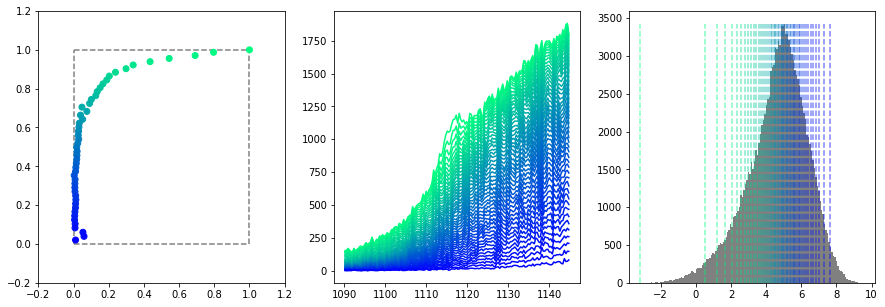

In [125]:
import importlib
hm = importlib.reload(hm)

p1 = cla1.predict_proba(pd.DataFrame(scaler_mc_1.transform(test_data[ML1]),columns=ML1))[:,0]

fig1, ax1 = plt.subplots(figsize = (15,5),ncols=3)

AUC1, cuts1 = hm.roc_curve_data(test_data.v0_la_mass, p1,bins=150,Npoints=50,range=mass_range,ax_roc=ax1[0],ax_fits=ax1[1],ax_hist=ax1[2],type='la')

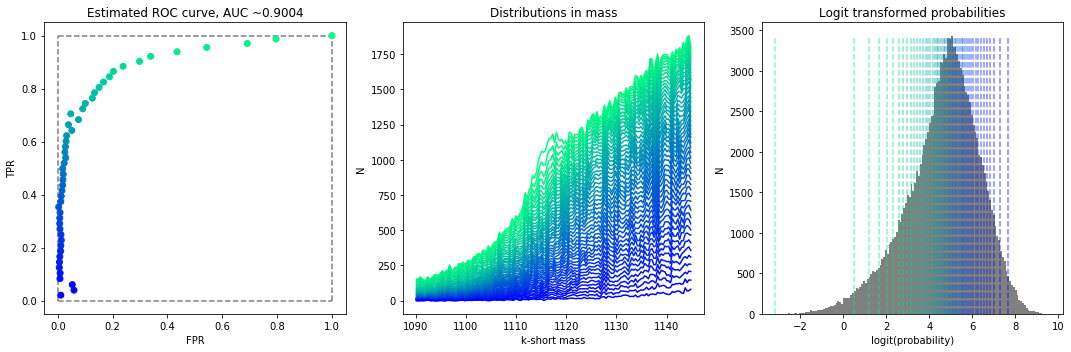

In [126]:
ax1[0].set(title=f'Estimated ROC curve, AUC ~{(1+AUC1):.4f}',xlabel='FPR',ylabel='TPR',xlim=(-0.05,1.05),ylim=(-0.05,1.05))
ax1[1].set(title='Distributions in mass',xlabel='k-short mass',ylabel='N')
ax1[2].set(title='Logit transformed probabilities',xlabel='logit(probability)',ylabel='N')
fig1.tight_layout()
# fig1.savefig('figures/ML1_roc_scaled_MC_lambda.pdf')
fig1

In [127]:
scaler_data_2, scaler_mc_2 = reweight_train(train_data,train_mc,ML2,cla2,reweighing=False,plot=False)

Completed fit with Chi2: 121.3, p-val: 0.019 and the total amount of signal 5475 +/- 137, background: 139585
Completed fit with Chi2: 120.1, p-val: 0.022 and the total amount of signal 3917 +/- 236, background: 138241
Completed fit with Chi2: 116.5, p-val: 0.037 and the total amount of signal 2216 +/- 203, background: 137041
Completed fit with Chi2: 133.0, p-val: 0.003 and the total amount of signal 1114 +/- 120, background: 135243
Completed fit with Chi2: 141.4, p-val: 0.001 and the total amount of signal 766 +/- 167, background: 132689
Completed fit with Chi2: 143.9, p-val: 0.000 and the total amount of signal 642 +/- 194, background: 129913
Completed fit with Chi2: 153.1, p-val: 0.000 and the total amount of signal 174 +/- 57, background: 127479
Completed fit with Chi2: 155.9, p-val: 0.000 and the total amount of signal 155 +/- 55, background: 124597
Completed fit with Chi2: 154.1, p-val: 0.000 and the total amount of signal 152 +/- 95, background: 121699
Completed fit with Chi2: 16

C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


Completed fit with Chi2: 94.8, p-val: 0.371 and the total amount of signal 44 +/- 1, background: 17365
Completed fit with Chi2: 94.1, p-val: 0.391 and the total amount of signal 23 +/- 21, background: 14483
Completed fit with Chi2: 100.7, p-val: 0.228 and the total amount of signal 4 +/- 0, background: 11602
Completed fit with Chi2: 99.6, p-val: 0.253 and the total amount of signal 13 +/- 0, background: 8692
Completed fit with Chi2: 115.1, p-val: 0.045 and the total amount of signal 14 +/- 6, background: 5790
Completed fit with Chi2: 94.7, p-val: 0.374 and the total amount of signal 33 +/- 14, background: 2870


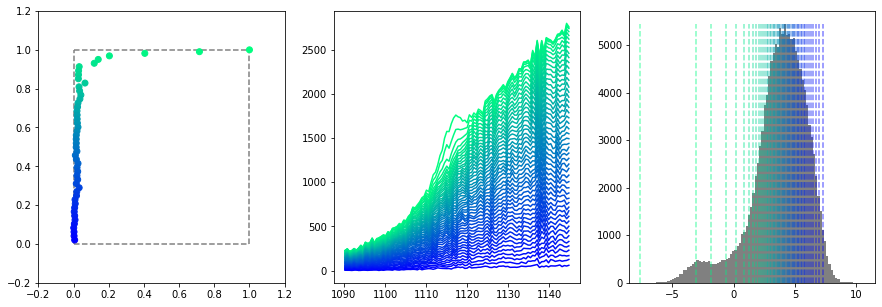

In [128]:
import importlib
hm = importlib.reload(hm)

p2 = cla2.predict_proba(pd.DataFrame(scaler_mc_2.transform(test_data[ML2]),columns=ML2))[:,0]

fig2, ax2 = plt.subplots(figsize = (15,5),ncols=3)

AUC2, cuts2 = hm.roc_curve_data(test_data.v0_la_mass, p2,Npoints=50,range=mass_range,ax_roc=ax2[0],ax_fits=ax2[1],ax_hist=ax2[2],type='la')

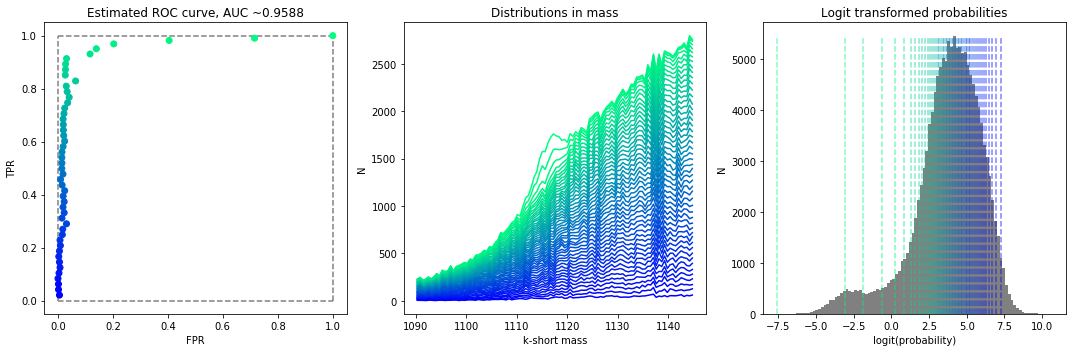

In [130]:
ax2[0].set(title=f'Estimated ROC curve, AUC ~{(1+AUC2):.4f}',xlabel='FPR',ylabel='TPR',xlim=(-0.05,1.05),ylim=(-0.05,1.05))
ax2[1].set(title='Distributions in mass',xlabel='k-short mass',ylabel='N')
ax2[2].set(title='Logit transformed probabilities',xlabel='logit(probability)',ylabel='N')
fig2.tight_layout()
# fig2.savefig('figures/ML2_roc_scaled_MC_lambda.pdf')
fig2

In [112]:
cla_reweight1 = xgb.XGBClassifier()
cla_reweight2 = xgb.XGBClassifier()
# cla1 = xgb.XGBClassifier()
# cla2 = xgb.XGBClassifier()

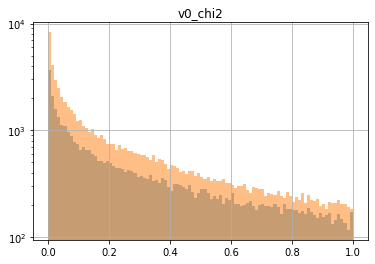

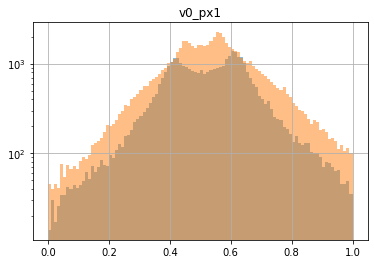

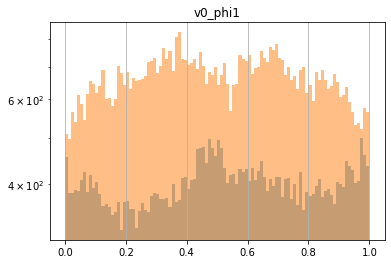

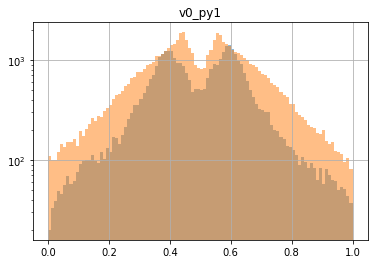

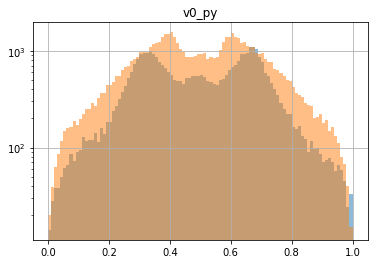

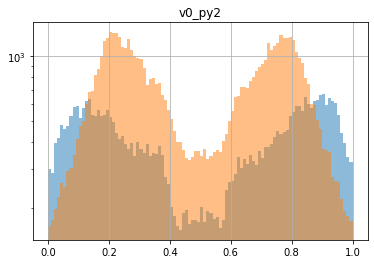

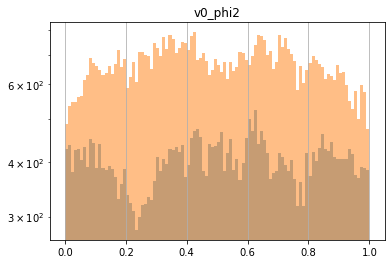

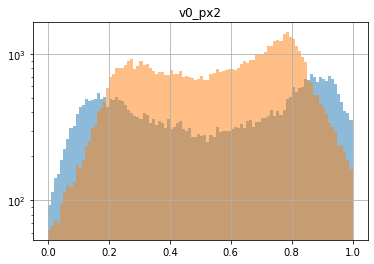

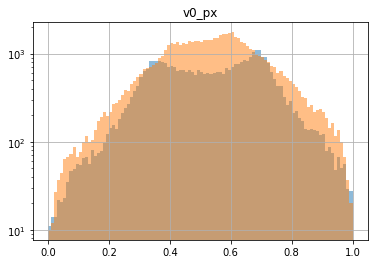

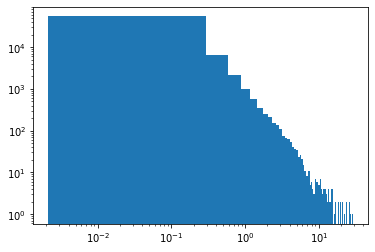

40166 66403


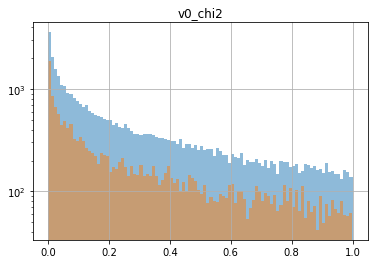

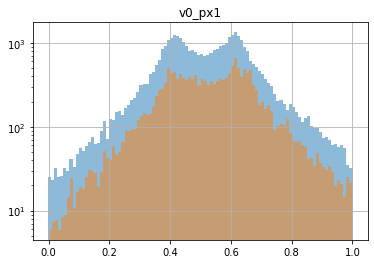

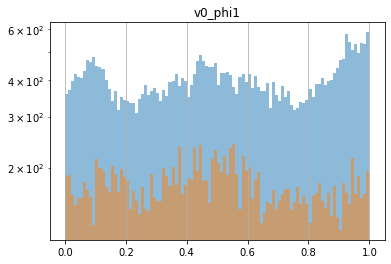

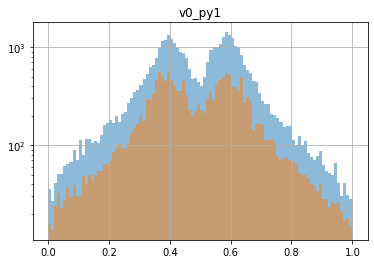

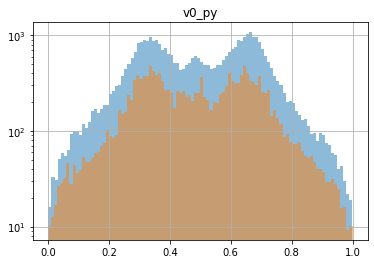

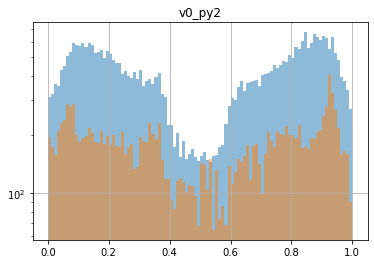

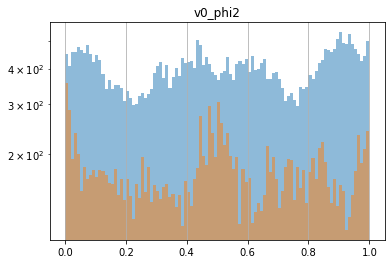

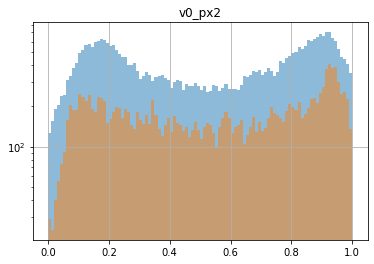

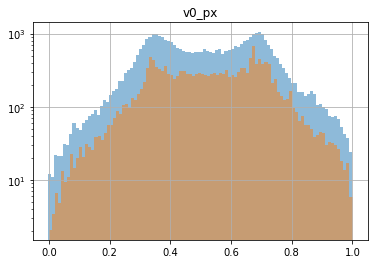

[0.01859938 0.14808506 0.07219963 0.1427657  0.12316806 0.14093529
 0.08155533 0.13381107 0.13888042]
[0.04395142 0.12831938 0.06186229 0.13358095 0.09580351 0.19451481
 0.0709604  0.17187193 0.09913529]


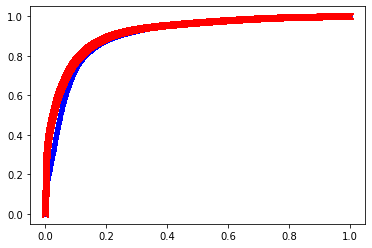

In [113]:
scaler_data_reweight1, scaler_mc_reweight1 = reweight_train(train_data,train_mc,ML1,cla_reweight1,test_data,test_mc,q_weights=0.999)

In [58]:
# scaler_data_1, scaler_mc_1 = reweight_train(train_data,train_mc,ML1,cla1,reweighing=False,plot=False)

Completed fit with Chi2: 121.3, p-val: 0.019 and the total amount of signal 5475 +/- 137, background: 139585
Completed fit with Chi2: 121.3, p-val: 0.019 and the total amount of signal 4286 +/- 132, background: 137872
Completed fit with Chi2: 121.7, p-val: 0.018 and the total amount of signal 3658 +/- 176, background: 135600
Completed fit with Chi2: 123.8, p-val: 0.013 and the total amount of signal 2851 +/- 209, background: 133505
No valid minimum found!
Completed fit with Chi2: 135.6, p-val: 0.002 and the total amount of signal 2288 +/- 3685, background: 131168
Completed fit with Chi2: 141.8, p-val: 0.001 and the total amount of signal 1804 +/- 199, background: 128750
Completed fit with Chi2: 148.7, p-val: 0.000 and the total amount of signal 1498 +/- 190, background: 126155
Completed fit with Chi2: 157.1, p-val: 0.000 and the total amount of signal 1324 +/- 194, background: 123428
Completed fit with Chi2: 166.3, p-val: 0.000 and the total amount of signal 1086 +/- 177, background: 1

C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


Completed fit with Chi2: 241.7, p-val: 0.000 and the total amount of signal 93 +/- 55, background: 75338
Completed fit with Chi2: 227.0, p-val: 0.000 and the total amount of signal 65 +/- 87, background: 72466
Completed fit with Chi2: 226.9, p-val: 0.000 and the total amount of signal 100 +/- 51, background: 69530
Completed fit with Chi2: 214.1, p-val: 0.000 and the total amount of signal 104 +/- 86, background: 66625
Completed fit with Chi2: 209.9, p-val: 0.000 and the total amount of signal 59 +/- 1, background: 63767
Completed fit with Chi2: 196.5, p-val: 0.000 and the total amount of signal 31 +/- 6, background: 60895
Completed fit with Chi2: 188.9, p-val: 0.000 and the total amount of signal 31 +/- 14, background: 57994
No valid minimum found!
Completed fit with Chi2: 174.2, p-val: 0.000 and the total amount of signal 37 +/- 5569, background: 55087
Completed fit with Chi2: 166.0, p-val: 0.000 and the total amount of signal 8 +/- 13, background: 52215
Completed fit with Chi2: 168.2

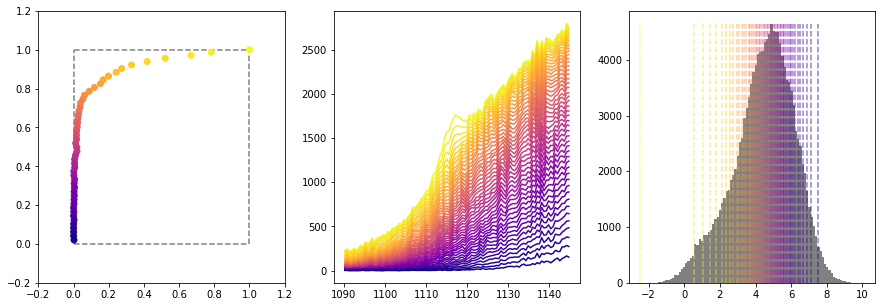

In [115]:
import importlib 
hm = importlib.reload(hm)

p1_reweight = cla_reweight1.predict_proba(pd.DataFrame(scaler_mc_reweight1.transform(test_data[ML1]),columns=ML1))[:,0]

fig1r, ax1r = plt.subplots(figsize = (15,5),ncols=3)

AUC1r, cuts1r = hm.roc_curve_data(test_data.v0_la_mass, p1_reweight,Npoints=50,range=mass_range,ax_roc=ax1r[0],ax_fits=ax1r[1],ax_hist=ax1r[2],type='la')

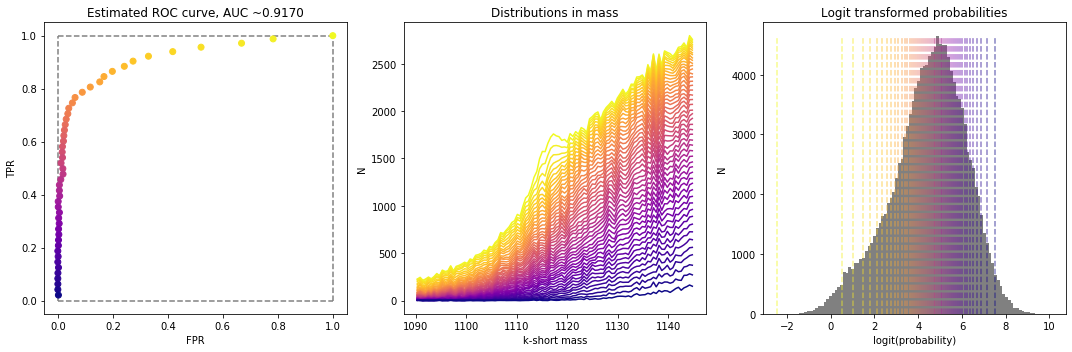

In [117]:
ax1r[0].set(title=f'Estimated ROC curve, AUC ~{(1+AUC1r):.4f}',xlabel='FPR',ylabel='TPR',xlim=(-0.05,1.05),ylim=(-0.05,1.05))
ax1r[1].set(title='Distributions in mass',xlabel='k-short mass',ylabel='N')
ax1r[2].set(title='Logit transformed probabilities',xlabel='logit(probability)',ylabel='N')
fig1r.tight_layout()
# fig1r.savefig('figures/ML1_roc_reweighted_MC_lambda.pdf')
fig1r

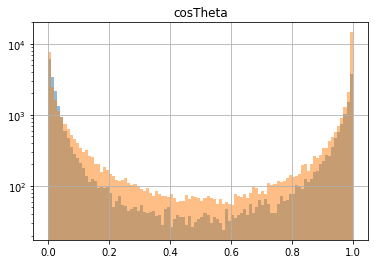

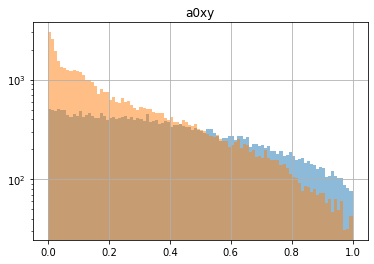

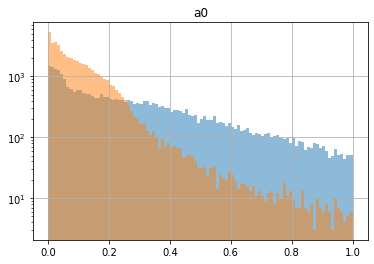

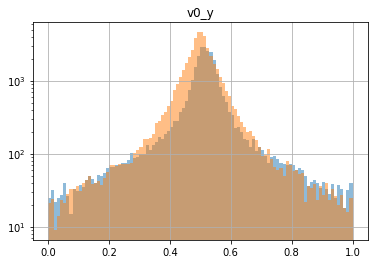

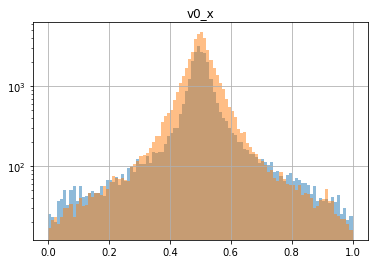

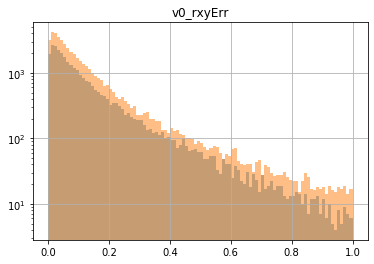

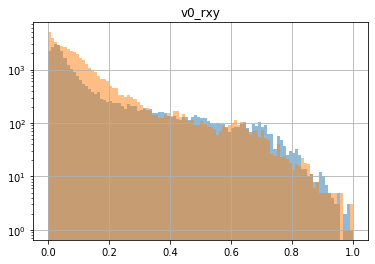

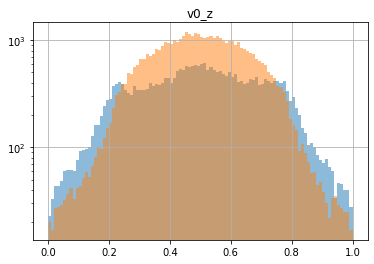

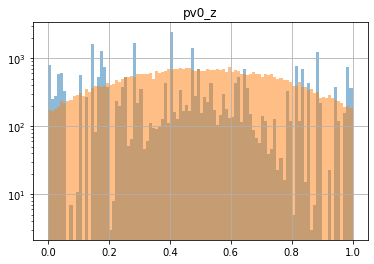

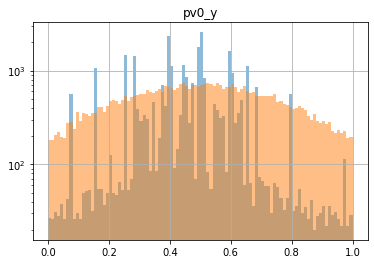

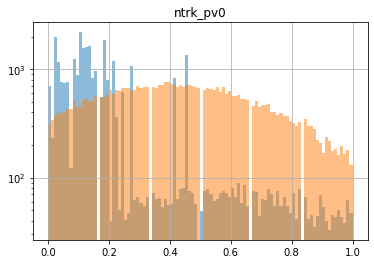

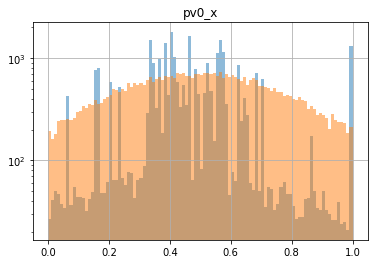

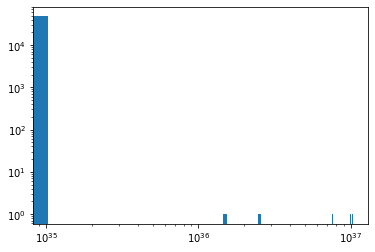

30240 47705


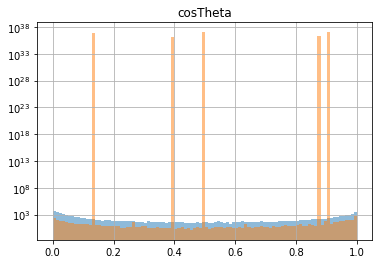

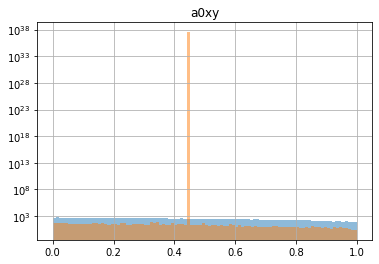

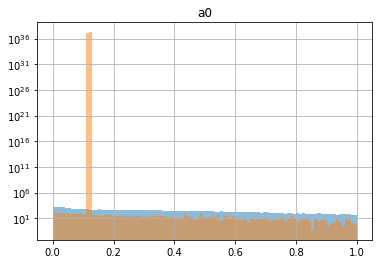

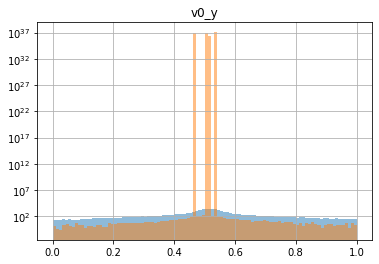

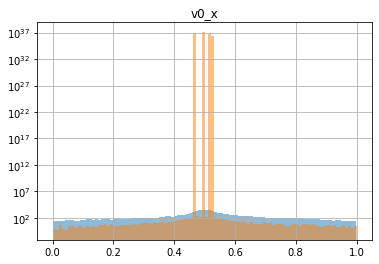

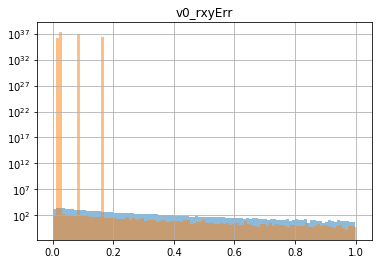

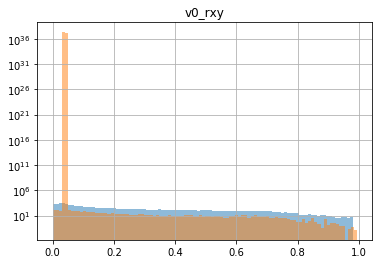

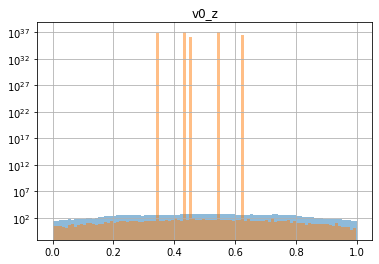

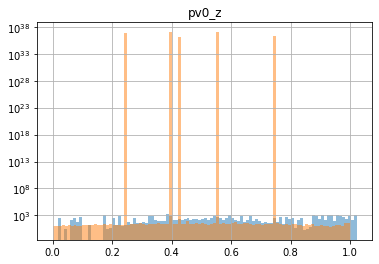

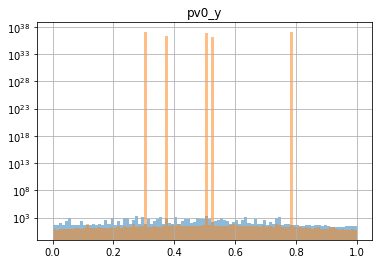

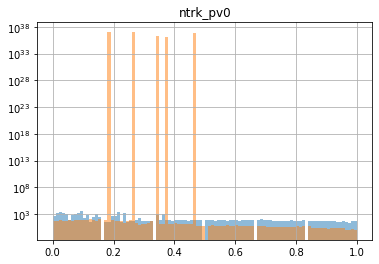

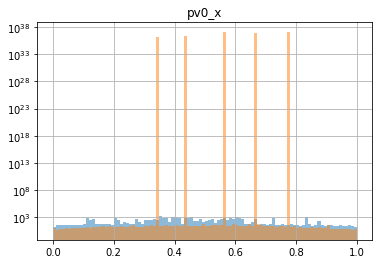

[8.1767803e-01 1.8231037e-01 1.0271393e-05 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.2839241e-06 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00]
[0.02017234 0.20008923 0.10561896 0.03308772 0.01221312 0.00754887
 0.03297739 0.01626936 0.09724047 0.06947919 0.3361959  0.06910748]


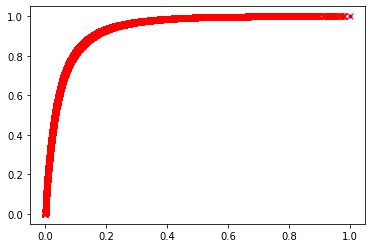

In [152]:
reweight_feats = "a0xy a0 v0_y v0_x v0_rxyErr v0_rxy v0_z ntrk_pv0".split(" ")
scaler_data_reweight2, scaler_mc_reweight2 = reweight_train(train_data,train_mc,ML2,cla_reweight2,reweight_feats,test_data,test_mc,q_weights=1)

Completed fit with Chi2: 121.3, p-val: 0.019 and the total amount of signal 5475 +/- 137, background: 139585
Completed fit with Chi2: 123.9, p-val: 0.012 and the total amount of signal 3691 +/- 147, background: 138467
Completed fit with Chi2: 122.1, p-val: 0.016 and the total amount of signal 2021 +/- 234, background: 137237
Completed fit with Chi2: 137.5, p-val: 0.001 and the total amount of signal 977 +/- 205, background: 135380
Completed fit with Chi2: 146.2, p-val: 0.000 and the total amount of signal 617 +/- 200, background: 132839
Completed fit with Chi2: 153.8, p-val: 0.000 and the total amount of signal 476 +/- 265, background: 130078
Completed fit with Chi2: 161.7, p-val: 0.000 and the total amount of signal 327 +/- 214, background: 127326


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


Completed fit with Chi2: 165.6, p-val: 0.000 and the total amount of signal 179 +/- 175, background: 124573
Completed fit with Chi2: 173.3, p-val: 0.000 and the total amount of signal 189 +/- 162, background: 121662
Completed fit with Chi2: 186.0, p-val: 0.000 and the total amount of signal 121 +/- 69, background: 118829
Completed fit with Chi2: 178.4, p-val: 0.000 and the total amount of signal 125 +/- 81, background: 115924
Completed fit with Chi2: 174.7, p-val: 0.000 and the total amount of signal 117 +/- 80, background: 113031
Completed fit with Chi2: 169.2, p-val: 0.000 and the total amount of signal 132 +/- 74, background: 110114
Completed fit with Chi2: 170.0, p-val: 0.000 and the total amount of signal 115 +/- 83, background: 107229
Completed fit with Chi2: 169.3, p-val: 0.000 and the total amount of signal 148 +/- 106, background: 104296
Completed fit with Chi2: 169.1, p-val: 0.000 and the total amount of signal 164 +/- 82, background: 101378
Completed fit with Chi2: 167.0, p-

C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


Completed fit with Chi2: 142.7, p-val: 0.000 and the total amount of signal 137 +/- 39, background: 66592
Completed fit with Chi2: 140.3, p-val: 0.001 and the total amount of signal 128 +/- 39, background: 63698
No valid minimum found!
Completed fit with Chi2: 138.5, p-val: 0.001 and the total amount of signal 114 +/- 3205, background: 60812
Completed fit with Chi2: 142.6, p-val: 0.000 and the total amount of signal 78 +/- 117, background: 57946
Completed fit with Chi2: 143.2, p-val: 0.000 and the total amount of signal 91 +/- 50, background: 55032
Completed fit with Chi2: 140.2, p-val: 0.001 and the total amount of signal 4 +/- 3, background: 52219
Completed fit with Chi2: 136.6, p-val: 0.001 and the total amount of signal 97 +/- 103, background: 49225
Completed fit with Chi2: 141.7, p-val: 0.001 and the total amount of signal 67 +/- 9, background: 46353
Completed fit with Chi2: 138.7, p-val: 0.001 and the total amount of signal 69 +/- 52, background: 43449
Completed fit with Chi2: 13

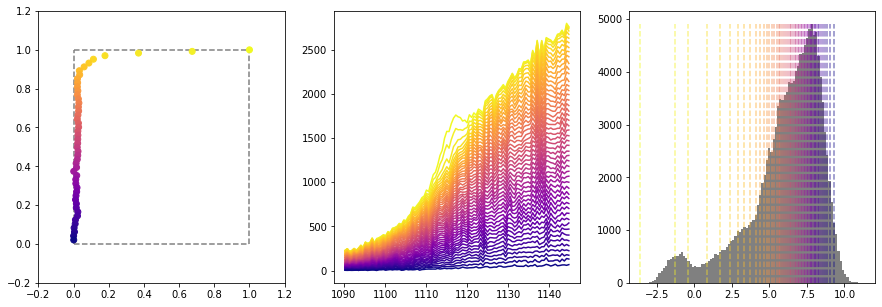

In [149]:
import importlib 
hm = importlib.reload(hm)

p2_reweight = cla_reweight2.predict_proba(pd.DataFrame(scaler_mc_reweight2.transform(test_data[ML2]),columns=ML2))[:,0]

fig2r, ax2r = plt.subplots(figsize = (15,5),ncols=3)

AUC2r, cuts2r = hm.roc_curve_data(test_data.v0_la_mass, p2_reweight,Npoints=50,range=mass_range,ax_roc=ax2r[0],ax_fits=ax2r[1],ax_hist=ax2r[2],type='la')

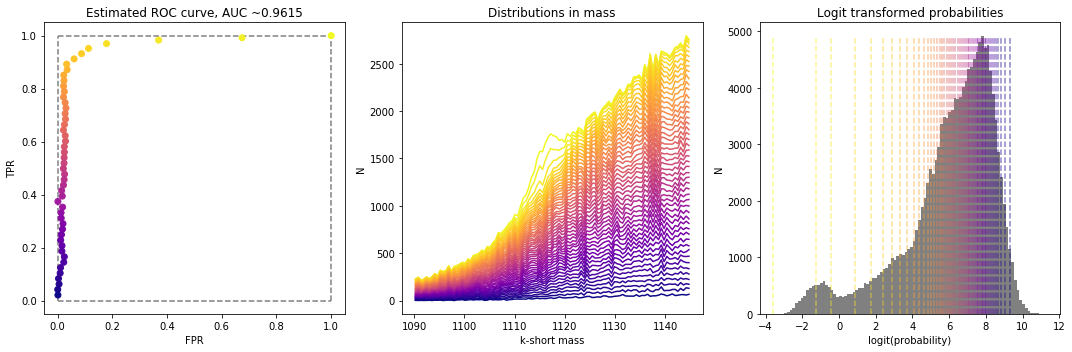

In [151]:
ax2r[0].set(title=f'Estimated ROC curve, AUC ~{(1+AUC2r):.4f}',xlabel='FPR',ylabel='TPR',xlim=(-0.05,1.05),ylim=(-0.05,1.05))
ax2r[1].set(title='Distributions in mass',xlabel='k-short mass',ylabel='N')
ax2r[2].set(title='Logit transformed probabilities',xlabel='logit(probability)',ylabel='N')
fig2r.tight_layout()
# fig2r.savefig('figures/ML2_roc_reweighted_MC_lambda.pdf')
fig2r